In [7]:
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
import diffrax as dfx
from PIL import Image
import numpy as np

from pde_opt.numerics.domains import Domain
from pde_opt.numerics.shapes import Shape
from pde_opt.numerics.equations.cahn_hilliard import CahnHilliard2DSmoothedBoundary
from pde_opt.pde_model import PDEModel

In [22]:
# Load image and convert to grayscale
img = Image.open('laplacian_big.png').convert('L')

# Convert to numpy array and binarize
img_array = np.array(img)
binary = (img_array > 128).astype(np.float32)  # Threshold at 128

# Convert to jax array
binary_mask = jnp.array(binary)


In [23]:
shape = Shape(
    binary=jnp.array(binary_mask),
    dx=(1.0, 1.0),
    smooth_epsilon=3.0,
    smooth_curvature=0.008,
    smooth_dt=0.01,
    smooth_tf=100.0,
)

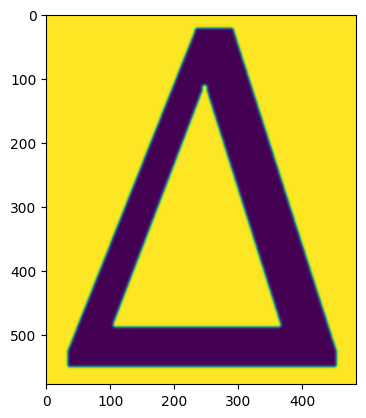

In [24]:
plt.imshow(shape.smooth)
plt.gca().set_aspect('equal')
plt.show()

In [25]:
Nx, Ny = binary_mask.shape
Lx = 0.01 * Nx
Ly = 0.01 * Ny

domain = Domain(
    (Nx, Ny), ((-Lx / 2, Lx / 2), (-Ly / 2, Ly / 2)), "dimensionless", shape
)

In [26]:
model = PDEModel(CahnHilliard2DSmoothedBoundary, domain, dfx.Tsit5)

In [27]:
t_start = 0.0
t_final = 0.1
dt = 0.000001
ts_save = jnp.linspace(t_start, t_final, 200)

In [42]:
pde_parameters = {
    "kappa": 0.002,
    "f": lambda c: c * jnp.log(c) + (1.0 - c) * jnp.log(1.0 - c) + 3.0 * c * (1.0 - c) + 0.059,
    "mu": lambda c: jnp.log(c / (1.0 - c)) + 3.0 * (1.0 - 2.0 * c),
    "D": lambda c: (1.0 - c) * c,
    "derivs": "fd",
    "theta": lambda t: jnp.pi / 2.0,
    "flux": lambda c: 0.0,
}

In [43]:
key = random.PRNGKey(5435)
u0 = 0.5 * jnp.ones((Nx, Ny)) + 0.1 * random.normal(key, (Nx, Ny))

In [44]:
solution = model.solve(
    pde_parameters,
    u0,
    ts_save,
    dt0=dt,
    stepsize_controller=dfx.PIDController(rtol=1e-4, atol=1e-6)
)

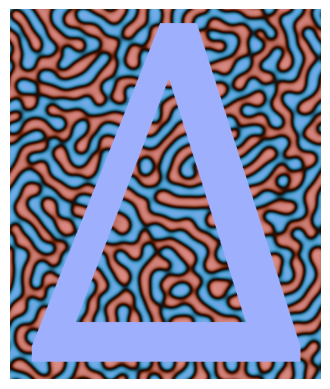

In [46]:
plt.imshow(solution[-1] * domain.geometry.binary, vmin=0.0, vmax=1.0, cmap='berlin')
plt.gca().set_aspect('equal')
plt.axis('off')
plt.show()